## 1.不同低秩分解方法实践
低秩分解是一种常用的模型压缩技术，其核心思想是将权重张量分解为多个低秩矩阵的乘积，从而减少参数量和计算量。本实践将展示几种常见的低秩分解方法。

下面我们将通过实际例子和可视化方式，直观地展示不同低秩分解方法的原理和效果。

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# 设置默认字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置种子以保证结果可复现
torch.manual_seed(42)
np.random.seed(42)

奇异值分解(Singular Value Decomposition, SVD)是一种常用的矩阵分解方法，可以将任意矩阵分解为三个矩阵的乘积：A = USV^T，其中U和V是正交矩阵，S是对角矩阵，对角线上的元素称为奇异值。

在神经网络压缩中，我们可以通过截断小的奇异值来实现低秩近似，从而减少参数量和计算量。

In [2]:
def plot_matrix(matrix, title, colorbar=True):
    """可视化矩阵"""
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(matrix.detach().numpy(), cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('Column Index')
    ax.set_ylabel('Row Index')
    
    # 添加颜色条
    if colorbar:
        plt.colorbar(im, ax=ax, label='Value')
    
    # 显示图像
    plt.tight_layout()
    plt.show()

def plot_singular_values(s, threshold=None, percentage=None):
    """可视化奇异值及其能量分布"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 绘制奇异值
    x_indices = np.arange(1, len(s) + 1)
    ax1.plot(x_indices, s.numpy(), 'o-', markersize=8)
    ax1.set_title('Singular Values')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Value')
    ax1.grid(True)

    if threshold is not None:
        ax1.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
        ax1.legend()
    
    # 绘制奇异值的累积能量
    energy = torch.cumsum(s**2, dim=0) / torch.sum(s**2)
    ax2.plot(x_indices, energy.numpy(), 'o-', markersize=8)
    ax2.set_title('Cumulative Energy')
    ax2.set_xlabel('Number of Singular Values')
    ax2.set_ylabel('Energy Percentage')
    ax2.grid(True)
    
    if percentage is not None:
        # 找到第一个超过百分比的索引
        idx = torch.where(energy >= percentage)[0][0].item()
        ax2.axhline(y=percentage, color='r', linestyle='--', 
                    label=f'{percentage*100:.0f}% Energy at k={idx+1}')
        ax2.axvline(x=idx+1, color='g', linestyle='--')
        ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return energy

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


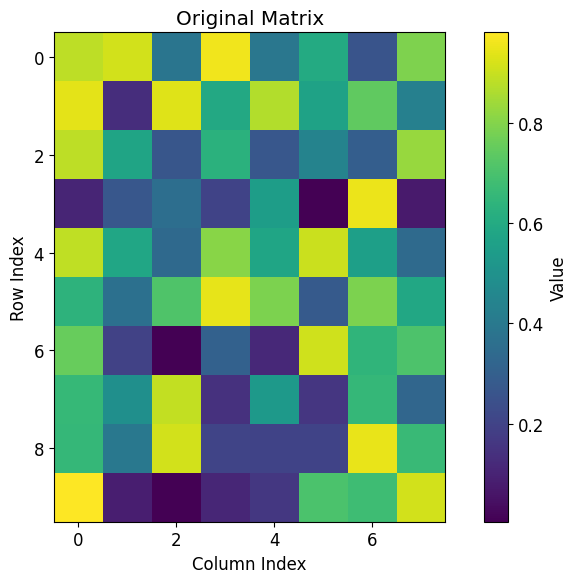

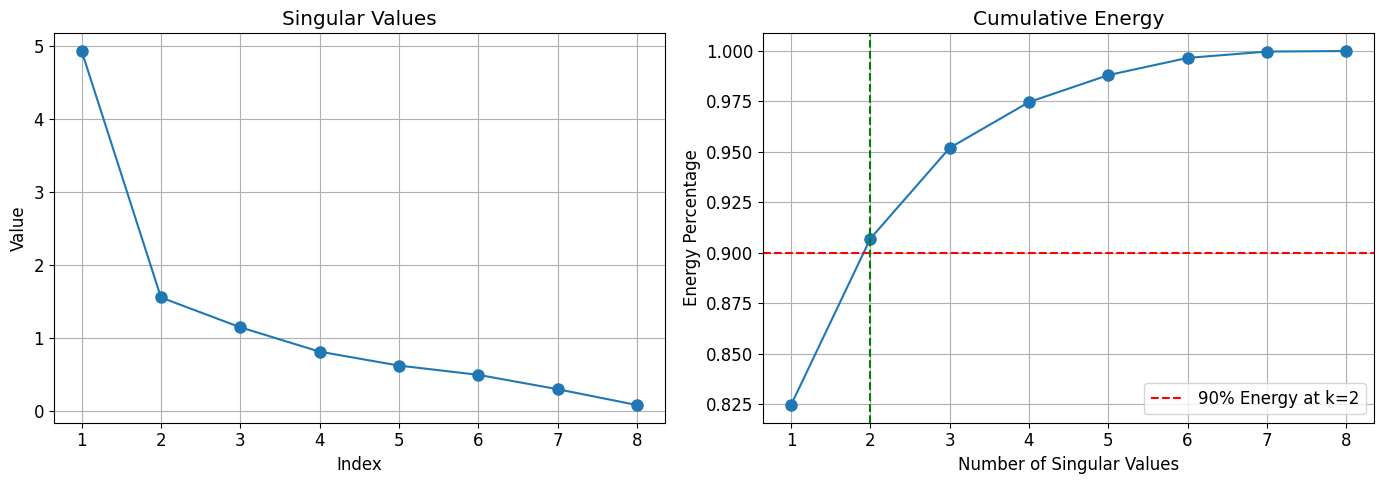

tensor([0.8245, 0.9070, 0.9520, 0.9747, 0.9881, 0.9966, 0.9997, 1.0000])

In [3]:
# 创建一个随机矩阵作为原始权重
original_matrix = torch.rand(10, 8)
plot_matrix(original_matrix, 'Original Matrix')

# 对矩阵进行SVD分解
U, S, V = torch.svd(original_matrix)

# 展示奇异值
plot_singular_values(S, percentage=0.9)

上面展示了一个随机生成的10×8矩阵及其奇异值分布。右侧图表显示了累积能量占比，可以看到只需要保留前几个奇异值就能保留矩阵大部分的信息。保留90%的能量只需要少量的奇异值。

接下来，我们将演示如何使用SVD进行低秩近似，并比较不同秩下的近似效果。

In [4]:
def low_rank_approximation(U, S, V, rank):
    """根据指定的秩进行低秩近似"""
    return U[:, :rank] @ torch.diag(S[:rank]) @ V[:, :rank].T

def compare_approximations(original, U, S, V, ranks):
    """比较不同秩下的近似效果，并添加原始矩阵作为参考"""
    # 添加原始矩阵
    all_displays = ranks + ['Original']
    
    fig, axes = plt.subplots(2, len(all_displays), figsize=(4*len(all_displays), 8))
    
    for i, rank in enumerate(ranks):
        # 低秩近似
        approx = low_rank_approximation(U, S, V, rank)
        
        # 计算误差
        error = torch.abs(original - approx)
        
        # 绘制近似结果
        im1 = axes[0, i].imshow(approx.detach().numpy(), cmap='viridis')
        axes[0, i].set_title(f'Rank-{rank} Approximation')
        axes[0, i].set_xlabel('Column Index')
        axes[0, i].set_ylabel('Row Index')
        plt.colorbar(im1, ax=axes[0, i])
        
        # 绘制误差
        im2 = axes[1, i].imshow(error.detach().numpy(), cmap='hot')
        axes[1, i].set_title(f'Error (Rank-{rank})')
        axes[1, i].set_xlabel('Column Index')
        axes[1, i].set_ylabel('Row Index')
        plt.colorbar(im2, ax=axes[1, i], label='Absolute Error')
    
    # 添加原始矩阵
    im_orig = axes[0, -1].imshow(original.detach().numpy(), cmap='viridis')
    axes[0, -1].set_title('Original Matrix')
    axes[0, -1].set_xlabel('Column Index')
    axes[0, -1].set_ylabel('Row Index')
    plt.colorbar(im_orig, ax=axes[0, -1])
    
    # 原始矩阵与自身的误差为零
    zeros = torch.zeros_like(original)
    im_error = axes[1, -1].imshow(zeros.detach().numpy(), cmap='hot')
    axes[1, -1].set_title('Error (Original)')
    axes[1, -1].set_xlabel('Column Index')
    axes[1, -1].set_ylabel('Row Index')
    plt.colorbar(im_error, ax=axes[1, -1], label='Absolute Error')
    
    plt.tight_layout()
    plt.show()

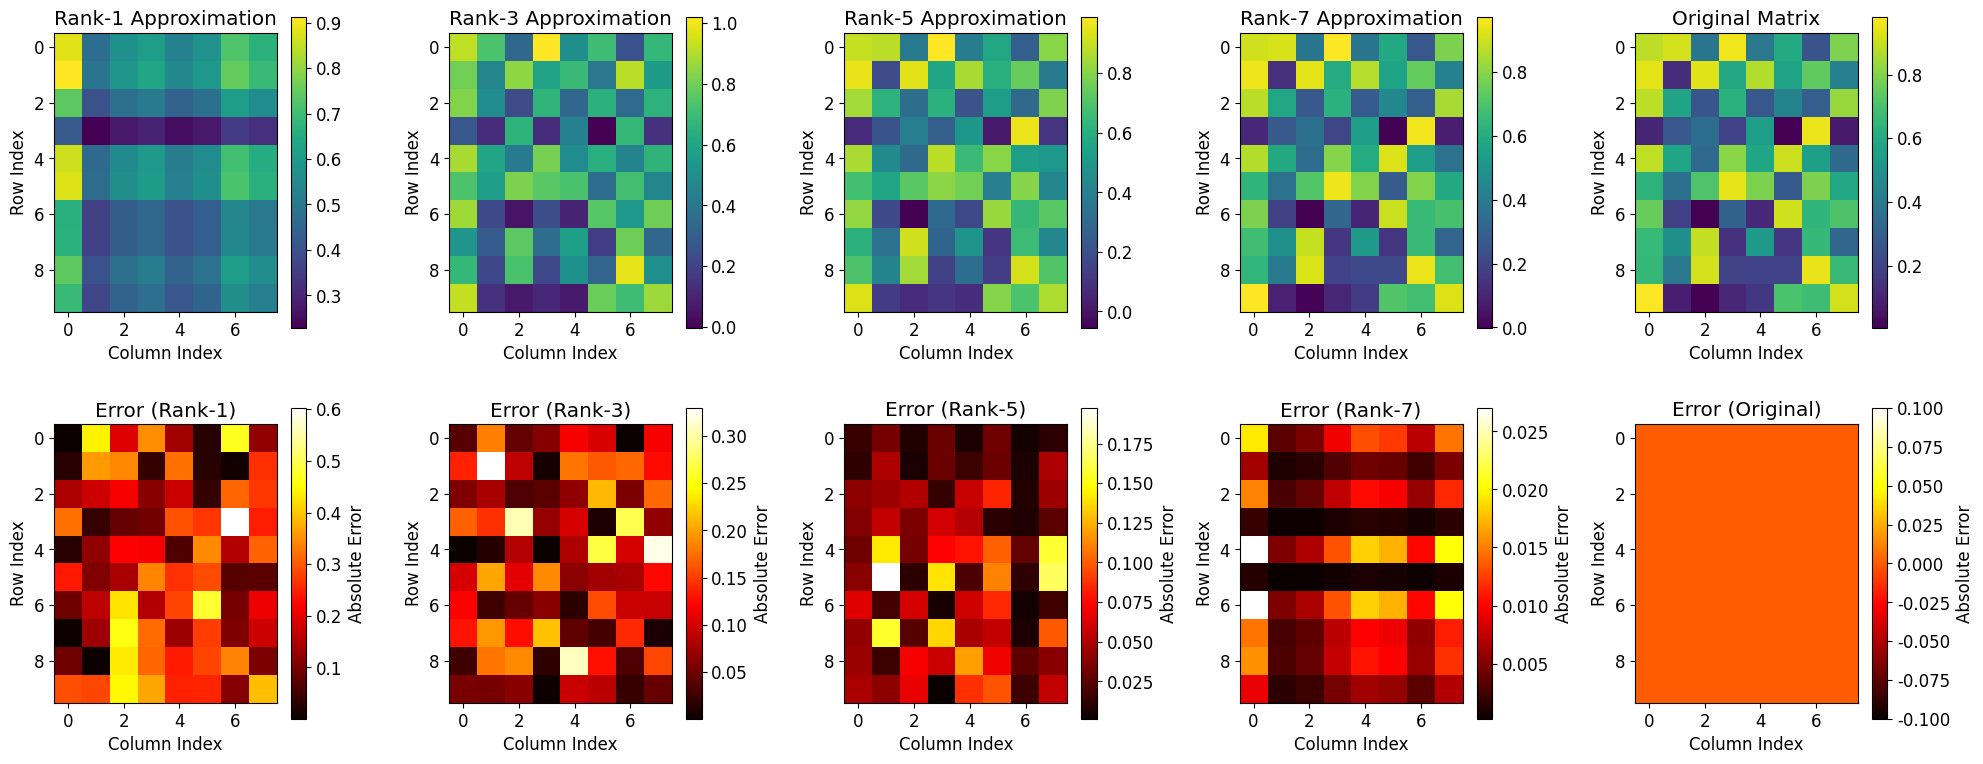

In [5]:
# 比较不同秩下的近似效果
ranks = [1, 3, 5, 7]
compare_approximations(original_matrix, U, S, V, ranks)

上图展示了不同秩下的低秩近似效果，并在最右侧添加了原始矩阵作为参考。随着秩的增加，近似效果逐渐提高，误差逐渐减小。当秩达到原始矩阵的秩时，近似误差为零。

在实际应用中，我们可以根据需要的精度和计算资源选择合适的秩。一般来说，保留90%-95%的能量通常是一个不错的选择。

In [6]:
# 计算不同秩下的压缩率和误差
def compression_analysis(original, U, S, V):
    """分析不同秩下的压缩率和误差"""
    original_params = original.numel()
    max_rank = min(original.shape)
    
    ranks = list(range(1, max_rank + 1))
    compression_ratios = []
    relative_errors = []
    
    for r in ranks:
        # 低秩分解后的参数量
        decomposed_params = U[:, :r].numel() + S[:r].numel() + V[:, :r].numel()
        
        # 压缩率 = 原参数量 / 分解后参数量
        compression_ratio = original_params / decomposed_params
        
        # 低秩近似
        approx = low_rank_approximation(U, S, V, r)
        
        # 相对误差 
        relative_error = torch.norm(original - approx, p='fro') / torch.norm(original, p='fro')
        
        compression_ratios.append(compression_ratio)
        relative_errors.append(relative_error.item())
    
    # 可视化结果
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(ranks, compression_ratios, 'o-', markersize=8)
    ax1.set_title('Compression Ratio vs Rank')
    ax1.set_xlabel('Rank')
    ax1.set_ylabel('Compression Ratio')
    ax1.grid(True)
    
    ax2.plot(ranks, relative_errors, 'o-', markersize=8)
    ax2.set_title('Relative Error vs Rank')
    ax2.set_xlabel('Rank')
    ax2.set_ylabel('Relative Error')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

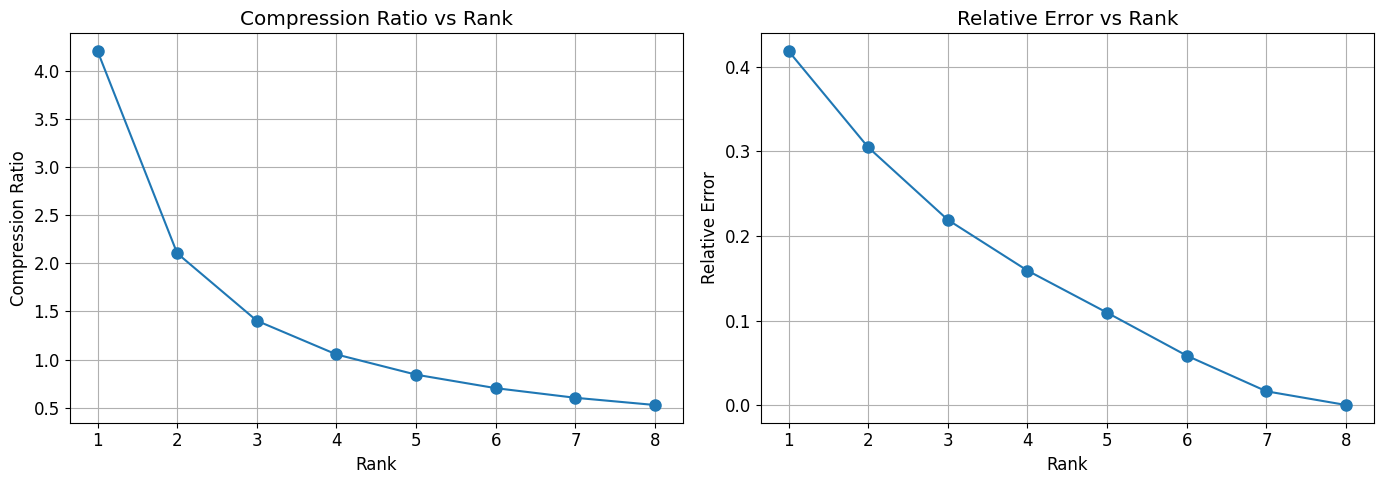

In [7]:
# 分析不同秩下的压缩率和误差
compression_analysis(original_matrix, U, S, V)

上图左侧显示了不同秩下的压缩率，可以看到当秩较小时，压缩率很高，但随着秩的增加，压缩率迅速下降。右侧显示了相对误差，随着秩的增加，相对误差逐渐减小。

低秩近似的关键在于找到合适的秩，既能保证足够的压缩率，又能控制误差在可接受范围内。

## SVD在图像压缩中的直观展示
SVD不仅可以用于神经网络压缩，还可以直接应用于图像压缩。下面我们将展示如何使用SVD对灰度图像进行压缩，并比较不同秩下的压缩效果。

In [8]:
def get_image():
    return Image.open("./Datawhale.jpg")

def compress_image_with_svd(image, ranks):
    """使用SVD对图像进行压缩"""
    # 转换为灰度图像并转为PyTorch张量
    if image.mode != 'L':
        image = image.convert('L')
    img_array = np.array(image)
    img_tensor = torch.tensor(img_array, dtype=torch.float32)
    
    # 对图像进行SVD分解
    U, S, V = torch.svd(img_tensor)
    
    # 创建不同秩下的近似图像
    approximations = []
    for r in ranks:
        approx = low_rank_approximation(U, S, V, r)
        approximations.append(approx)
    
    return img_tensor, U, S, V, approximations

def plot_image_compression(original, approximations, ranks, percentage=None):
    """可视化图像压缩效果"""
    n_ranks = len(ranks)
    fig, axes = plt.subplots(2, n_ranks + 1, figsize=(4*(n_ranks + 1), 8))
    
    # 显示原始图像
    axes[0, 0].imshow(original.numpy(), cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # 显示原始图像与自身的误差
    axes[1, 0].imshow(torch.zeros_like(original).numpy(), cmap='hot')
    axes[1, 0].set_title('Error (Original)')
    axes[1, 0].axis('off')
    
    # 显示不同秩下的近似图像和误差
    for i, (approx, rank) in enumerate(zip(approximations, ranks)):
        # 确保像素值在合理范围内
        approx_clamped = torch.clamp(approx, 0, 255)
        
        # 显示近似图像
        axes[0, i+1].imshow(approx_clamped.numpy(), cmap='gray')
        axes[0, i+1].set_title(f'Rank-{rank} Approximation')
        axes[0, i+1].axis('off')
        
        # 计算并显示误差
        error = torch.abs(original - approx_clamped)
        axes[1, i+1].imshow(error.numpy(), cmap='hot')
        axes[1, i+1].set_title(f'Error (Rank-{rank})')
        axes[1, i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 如果提供了百分比，显示SVD能量分布
    if percentage is not None:
        plot_singular_values(S, percentage=percentage)
    
    # 显示压缩率和保留信息比例
    max_rank = min(original.shape)
    compression_info = []
    for r in ranks:
        # 原始参数量
        original_params = original.numel()
        
        # 压缩后参数量
        compressed_params = U[:, :r].numel() + S[:r].numel() + V[:, :r].numel()
        
        # 压缩率
        compression_ratio =  ( original_params - compressed_params ) / original_params
        
        # 保留能量比例
        energy_ratio = torch.sum(S[:r]**2) / torch.sum(S**2)
        
        compression_info.append((r, compression_ratio, energy_ratio))
    
    # 显示压缩信息
    print("Rank\tCompression Ratio\tEnergy Preserved")
    print("----\t-----------------\t----------------")
    for r, ratio, energy in compression_info:
        print(f"{r}\t{ratio:.2f}\t\t\t{energy:.4f}")

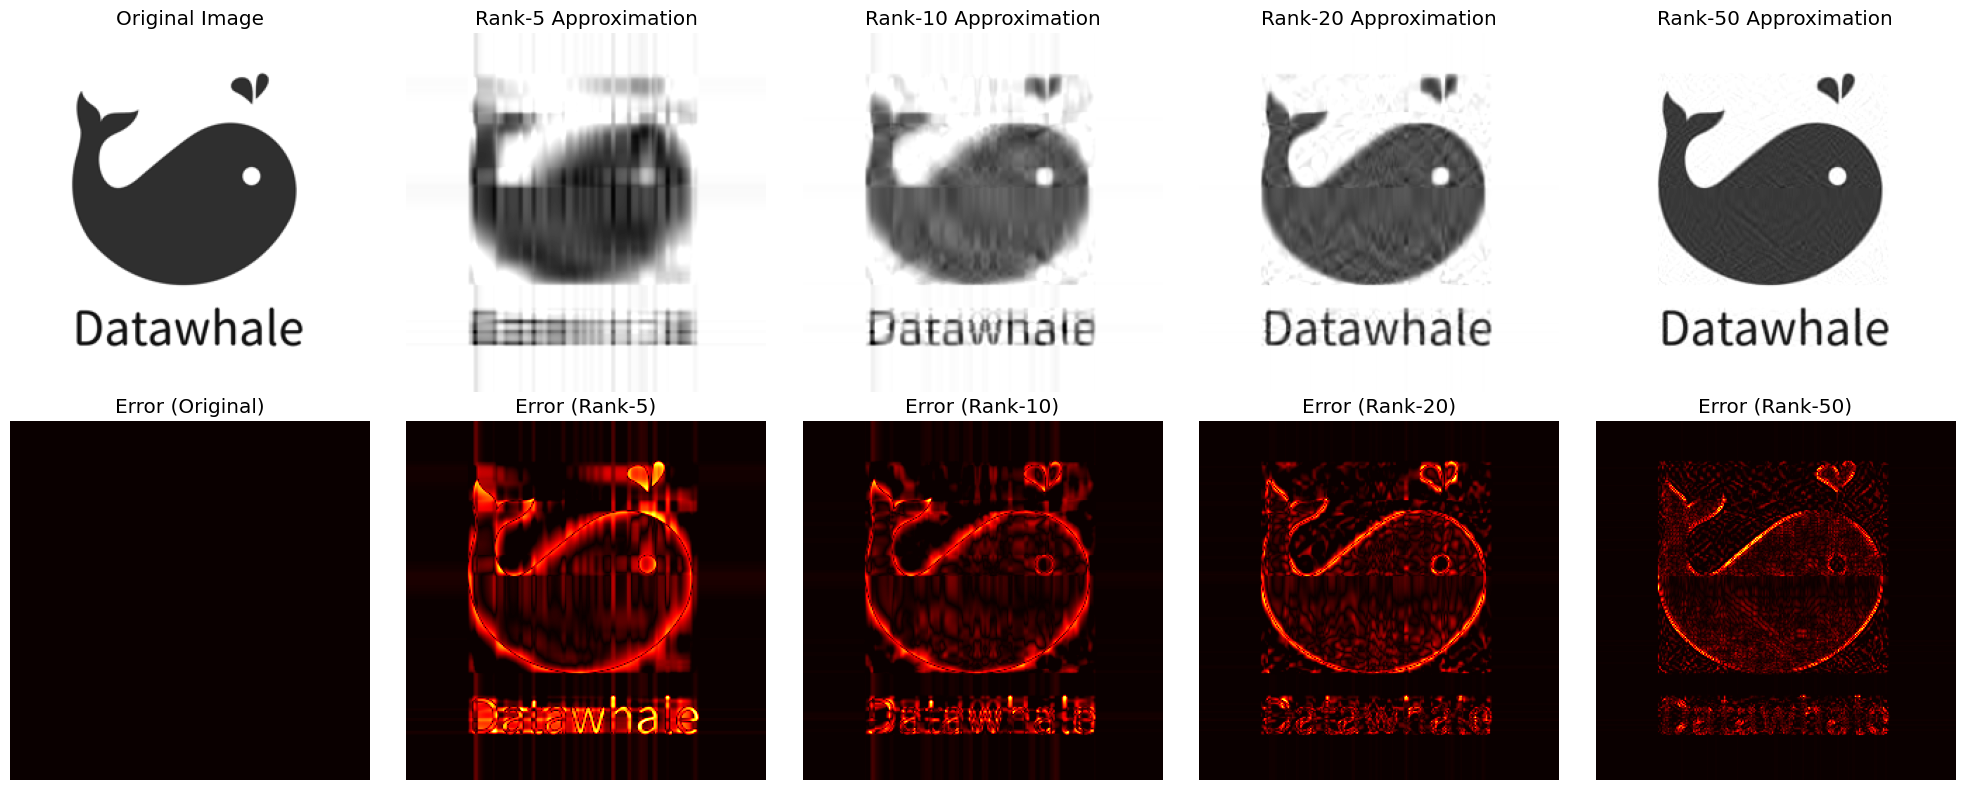

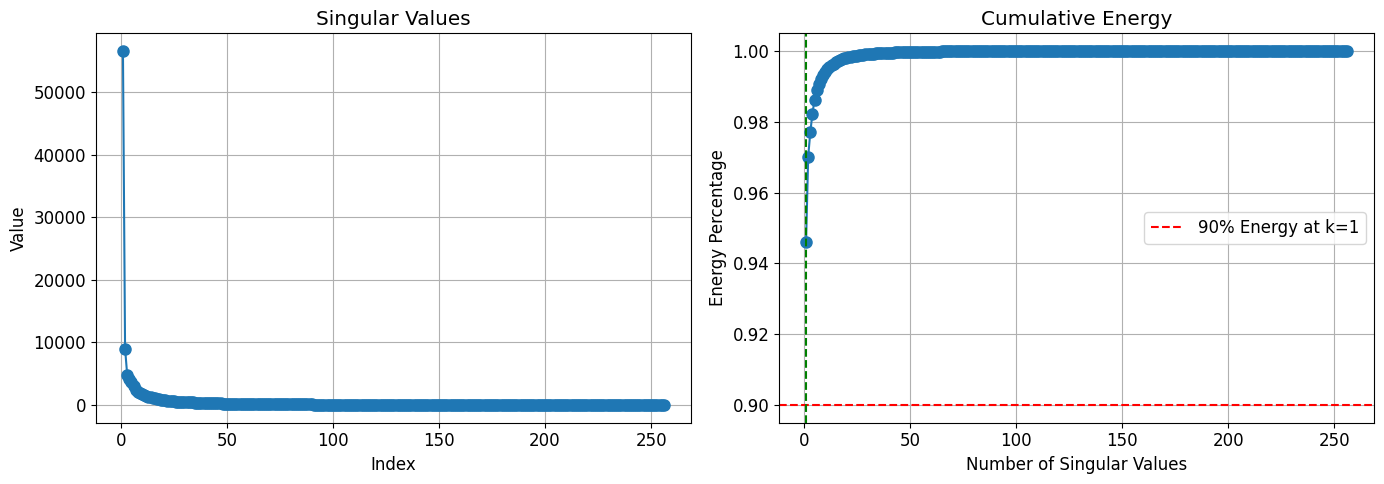

Rank	Compression Ratio	Energy Preserved
----	-----------------	----------------
5	0.96			0.9863
10	0.92			0.9941
20	0.84			0.9981
50	0.61			0.9997


In [9]:
# 下载并压缩经典测试图像
img = get_image()


# 调整图像大小以加快计算速度
img = img.resize((256, 256))

# 设置不同的秩
ranks = [5, 10, 20, 50]

# 使用SVD压缩图像
original, U, S, V, approximations = compress_image_with_svd(img, ranks)

# 可视化压缩效果
plot_image_compression(original, approximations, ranks, percentage=0.9)

上图展示了使用SVD对经典测试图像进行压缩的效果。随着保留秩的增加，图像质量逐渐提高，误差逐渐减小。

从数据中可以看出，即使只保留少量的奇异值，也能保留图像的大部分信息。例如，使用秩为50的近似，已经能够很好地重建原始图像，同时实现了显著的数据压缩。

这种图像压缩方法是SVD在实际应用中的一个典型例子，也直观地展示了低秩近似的强大之处。

## 高阶张量的Tucker分解
Tucker分解是一种高阶张量分解方法，可以看作是SVD在高阶张量上的推广。对于一个三阶张量X，Tucker分解可以表示为X ≈ G ×₁ A ×₂ B ×₃ C，其中G是核心张量，A、B、C是因子矩阵，×ᵢ表示第i模式的张量-矩阵乘积。

Tucker分解可以捕捉张量中的多维相关性，是一种更灵活的张量分解方法。

In [10]:
def visualize_3d_tensor(tensor, title, alpha=0.8):
    """
    使用3D散点图可视化三阶张量，点的大小和颜色表示值的大小
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 获取张量的尺寸和数值
    dim1, dim2, dim3 = tensor.shape
    tensor_np = tensor.detach().numpy()
    
    # 创建坐标网格
    x, y, z = np.meshgrid(np.arange(dim1), np.arange(dim2), np.arange(dim3), indexing='ij')
    
    # 展平数组
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    values_flat = tensor_np.flatten()
    
    # 过滤掉接近零的值以减少视觉混乱
    threshold = np.percentile(np.abs(values_flat), 70)
    mask = np.abs(values_flat) >= threshold
    
    x_filtered = x_flat[mask]
    y_filtered = y_flat[mask]
    z_filtered = z_flat[mask]
    values_filtered = values_flat[mask]
    
    # 设置点的大小和颜色
    sizes = 200 * (np.abs(values_filtered) / np.max(np.abs(values_filtered)))
    colors = values_filtered
    
    # 绘制散点图
    scatter = ax.scatter(x_filtered, y_filtered, z_filtered, 
                        c=colors, s=sizes, alpha=alpha, cmap='viridis')
    
    # 设置标题和轴标签
    ax.set_title(f'{title}\nShape: {tensor.shape}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    
    # 添加颜色条
    plt.colorbar(scatter, ax=ax, label='Value', shrink=0.8)
    
    plt.tight_layout()
    plt.show()

def tucker_decomposition(tensor, ranks):
    """对张量进行Tucker分解"""
    tensor_np = tensor.detach().numpy()
    tl.set_backend('numpy')
    
    # 进行Tucker分解
    core, factors = tucker(tensor_np, rank=ranks)
    
    # 转回PyTorch张量
    core_tensor = torch.tensor(core, dtype=torch.float32)
    factor_matrices = [torch.tensor(factor, dtype=torch.float32) for factor in factors]
    
    return core_tensor, factor_matrices

def reconstruct_from_tucker(core_tensor, factor_matrices):
    """从Tucker分解重建张量"""
    core_np = core_tensor.detach().numpy()
    factors_np = [factor.detach().numpy() for factor in factor_matrices]
    
    tl.set_backend('numpy')
    reconstructed_np = tl.tucker_to_tensor((core_np, factors_np))
    
    return torch.tensor(reconstructed_np, dtype=torch.float32)

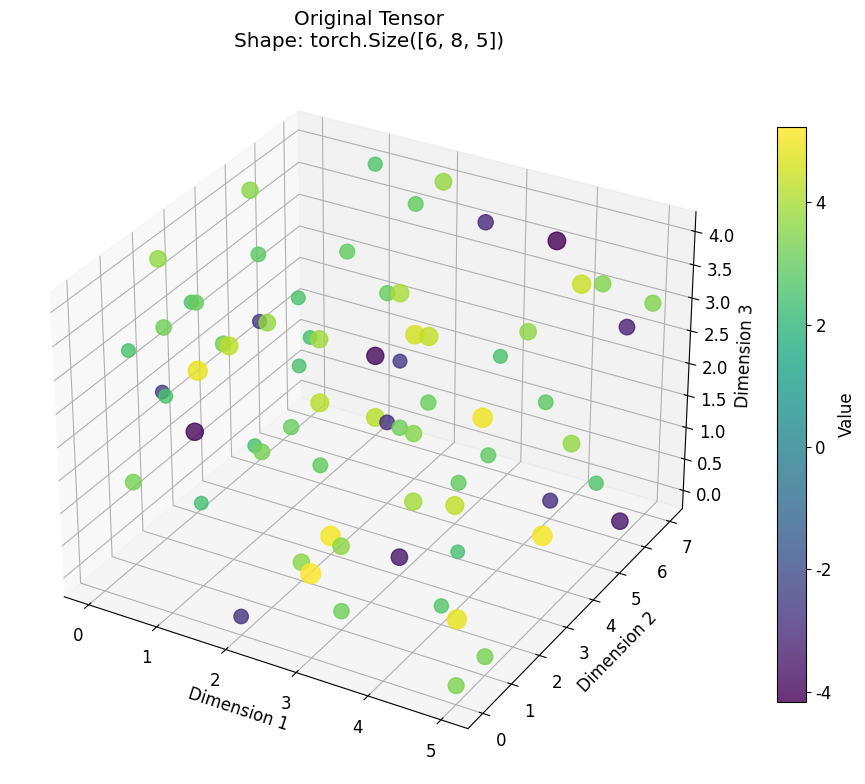

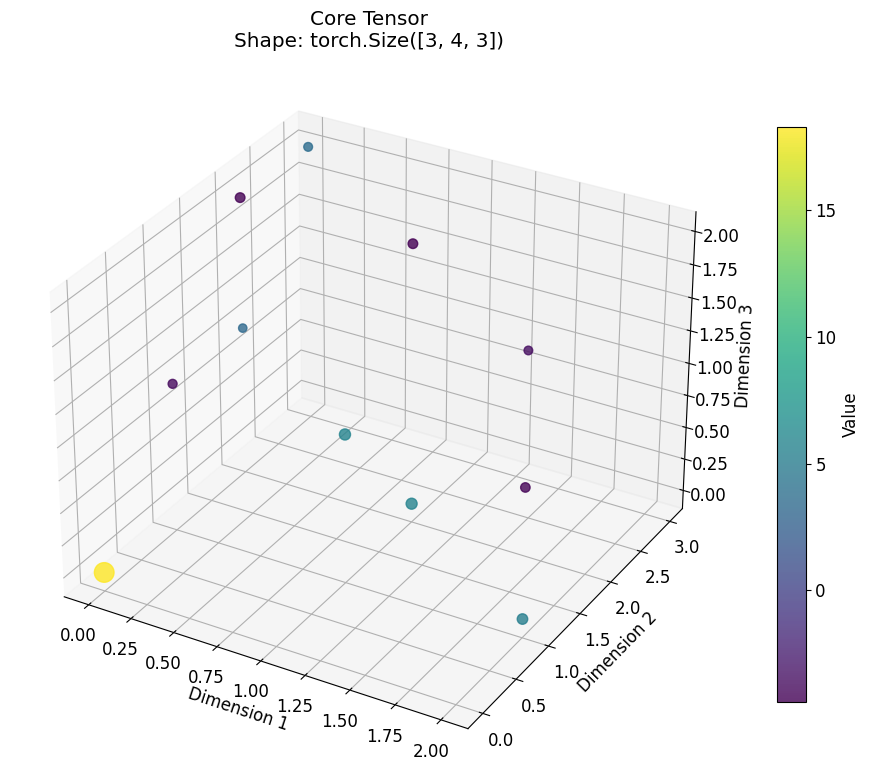

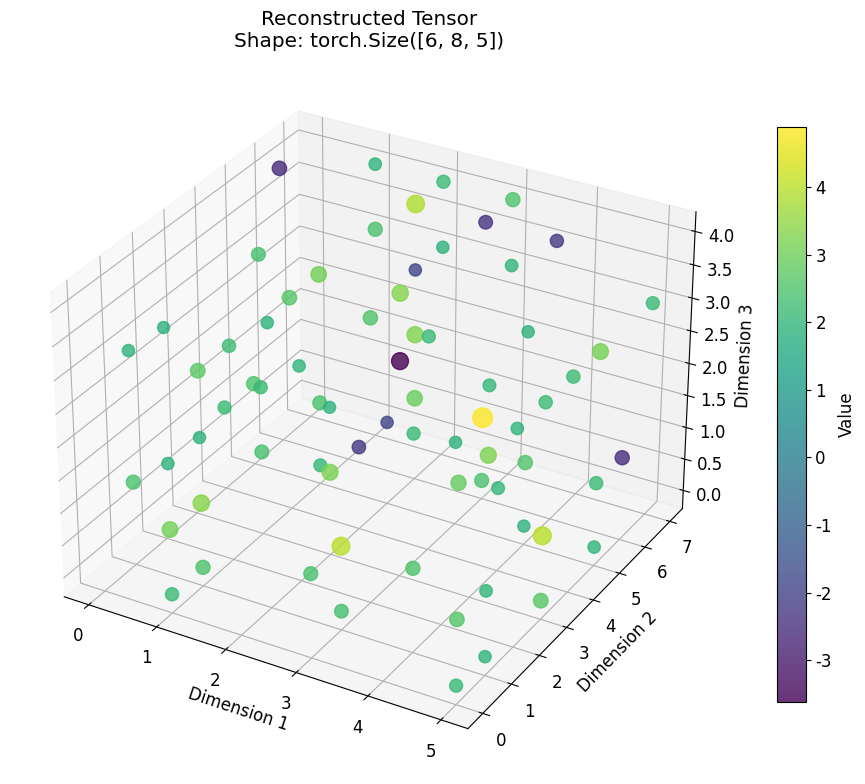

原始参数量: 240
压缩后参数量: 101
压缩率: 2.38
相对误差: 0.686360


In [11]:
# 创建一个三阶张量
original_tensor = torch.randn(6, 8, 5) * 2 + 1

# 可视化原始张量
visualize_3d_tensor(original_tensor, 'Original Tensor')

# 设置Tucker分解的秩
tucker_ranks = [3, 4, 3]

# 进行Tucker分解
core_tensor, factor_matrices = tucker_decomposition(original_tensor, tucker_ranks)

# 可视化核心张量
visualize_3d_tensor(core_tensor, 'Core Tensor')

# 重建张量
reconstructed_tensor = reconstruct_from_tucker(core_tensor, factor_matrices)

# 可视化重建张量
visualize_3d_tensor(reconstructed_tensor, 'Reconstructed Tensor')

# 计算压缩效果
original_params = original_tensor.numel()
compressed_params = core_tensor.numel() + sum(f.numel() for f in factor_matrices)
compression_ratio = original_params / compressed_params
relative_error = torch.norm(original_tensor - reconstructed_tensor) / torch.norm(original_tensor)

print(f'原始参数量: {original_params}')
print(f'压缩后参数量: {compressed_params}')
print(f'压缩率: {compression_ratio:.2f}')
print(f'相对误差: {relative_error.item():.6f}')

上图展示了Tucker分解的三维可视化效果。原始张量、核心张量和重建张量都用散点图表示，其中点的大小表示数值的绝对值大小，颜色表示数值的正负和大小。

可以看到核心张量比原始张量更小更稀疏，但重建张量能够很好地近似原始张量的结构。Tucker分解通过将高维张量分解为低维的核心张量和因子矩阵，实现了有效的数据压缩。


## CP分解
CP分解是另一种重要的张量分解方法，它将一个三阶张量分解为有限个秩1张量的和。与Tucker分解不同，CP分解没有核心张量，而是直接将张量表示为因子矩阵的外积和。


In [12]:
from tensorly.decomposition import parafac

def cp_decomposition(tensor, rank):
    """对张量进行CP分解"""
    tensor_np = tensor.detach().numpy()
    tl.set_backend('numpy')
    
    # 进行CP分解
    weights, factors = parafac(tensor_np, rank=rank)
    
    # 转回PyTorch张量
    weights_tensor = torch.tensor(weights, dtype=torch.float32)
    factor_matrices = [torch.tensor(factor, dtype=torch.float32) for factor in factors]
    
    return weights_tensor, factor_matrices

def reconstruct_from_cp(weights, factor_matrices):
    """从CP分解重建张量"""
    weights_np = weights.detach().numpy()
    factors_np = [factor.detach().numpy() for factor in factor_matrices]
    
    tl.set_backend('numpy')
    reconstructed_np = tl.cp_to_tensor((weights_np, factors_np))
    
    return torch.tensor(reconstructed_np, dtype=torch.float32)

def visualize_cp_factors(factor_matrices, weights):
    """可视化CP分解的因子矩阵"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, factor in enumerate(factor_matrices):
        # 显示因子矩阵，每列对应一个成分
        im = axes[i].imshow(factor.detach().numpy(), cmap='RdBu_r', aspect='auto')
        axes[i].set_title(f'Factor Matrix {i+1}')
        axes[i].set_xlabel('Component')
        axes[i].set_ylabel(f'Dimension {i+1}')
        plt.colorbar(im, ax=axes[i])
    
    plt.tight_layout()
    plt.show()

def compare_cp_ranks(original_tensor, rank_list):
    """比较不同秩下的CP分解效果"""
    errors = []
    compression_ratios = []
    original_params = original_tensor.numel()
    
    fig, axes = plt.subplots(2, len(rank_list), figsize=(4*len(rank_list), 8))
    
    for i, rank in enumerate(rank_list):
        # 进行CP分解
        weights, factors = cp_decomposition(original_tensor, rank)
        
        # 重建张量
        reconstructed = reconstruct_from_cp(weights, factors)
        
        # 计算误差
        error = torch.norm(original_tensor - reconstructed) / torch.norm(original_tensor)
        errors.append(error.item())
        
        # 计算压缩率
        compressed_params = weights.numel() + sum(f.numel() for f in factors)
        compression_ratio = original_params / compressed_params
        compression_ratios.append(compression_ratio)
        
        # 可视化重建效果（显示第一个切片）
        axes[0, i].imshow(reconstructed[0].detach().numpy(), cmap='viridis')
        axes[0, i].set_title(f'Rank-{rank} Reconstruction')
        axes[0, i].axis('off')
        
        # 显示误差
        error_slice = torch.abs(original_tensor[0] - reconstructed[0])
        axes[1, i].imshow(error_slice.detach().numpy(), cmap='hot')
        axes[1, i].set_title(f'Error (Rank-{rank})')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 显示压缩率和误差统计
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(rank_list, compression_ratios, 'o-', markersize=8)
    ax1.set_title('Compression Ratio vs CP Rank')
    ax1.set_xlabel('CP Rank')
    ax1.set_ylabel('Compression Ratio')
    ax1.grid(True)
    
    ax2.plot(rank_list, errors, 'o-', markersize=8, color='red')
    ax2.set_title('Relative Error vs CP Rank')
    ax2.set_xlabel('CP Rank')
    ax2.set_ylabel('Relative Error')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return errors, compression_ratios

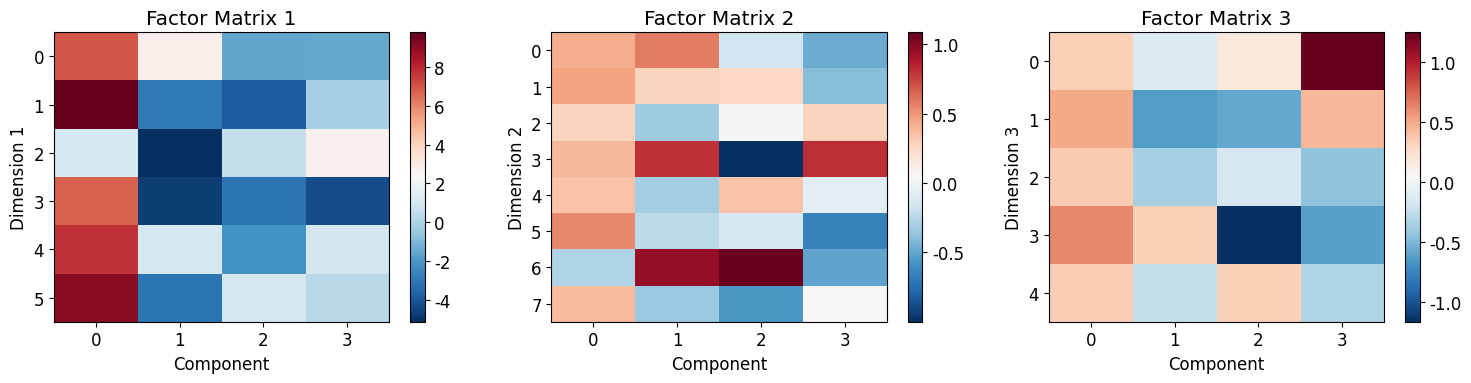

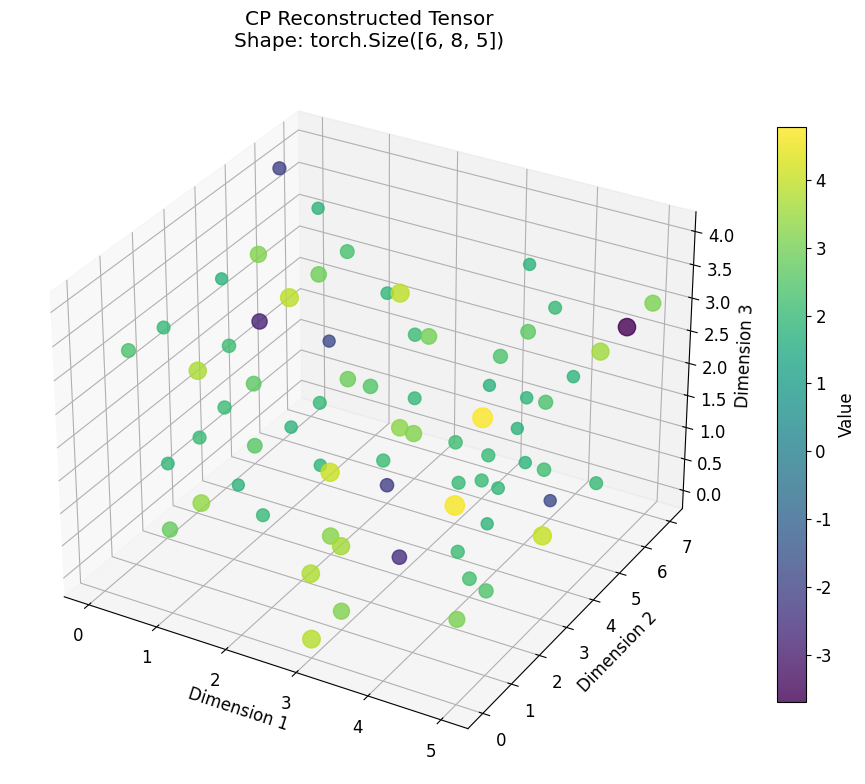

CP分解 - 原始参数量: 240
CP分解 - 压缩后参数量: 80
CP分解 - 压缩率: 3.00
CP分解 - 相对误差: 0.655080


In [13]:
# 设置CP分解的秩
cp_rank = 4

# 进行CP分解
weights, factor_matrices = cp_decomposition(original_tensor, cp_rank)

# 可视化因子矩阵和权重
visualize_cp_factors(factor_matrices, weights)

# 重建张量
reconstructed_cp = reconstruct_from_cp(weights, factor_matrices)

# 可视化重建效果
visualize_3d_tensor(reconstructed_cp, 'CP Reconstructed Tensor')

# 计算CP分解的压缩效果
cp_original_params = original_tensor.numel()
cp_compressed_params = weights.numel() + sum(f.numel() for f in factor_matrices)
cp_compression_ratio = cp_original_params / cp_compressed_params
cp_relative_error = torch.norm(original_tensor - reconstructed_cp) / torch.norm(original_tensor)

print(f'CP分解 - 原始参数量: {cp_original_params}')
print(f'CP分解 - 压缩后参数量: {cp_compressed_params}')
print(f'CP分解 - 压缩率: {cp_compression_ratio:.2f}')
print(f'CP分解 - 相对误差: {cp_relative_error.item():.6f}')

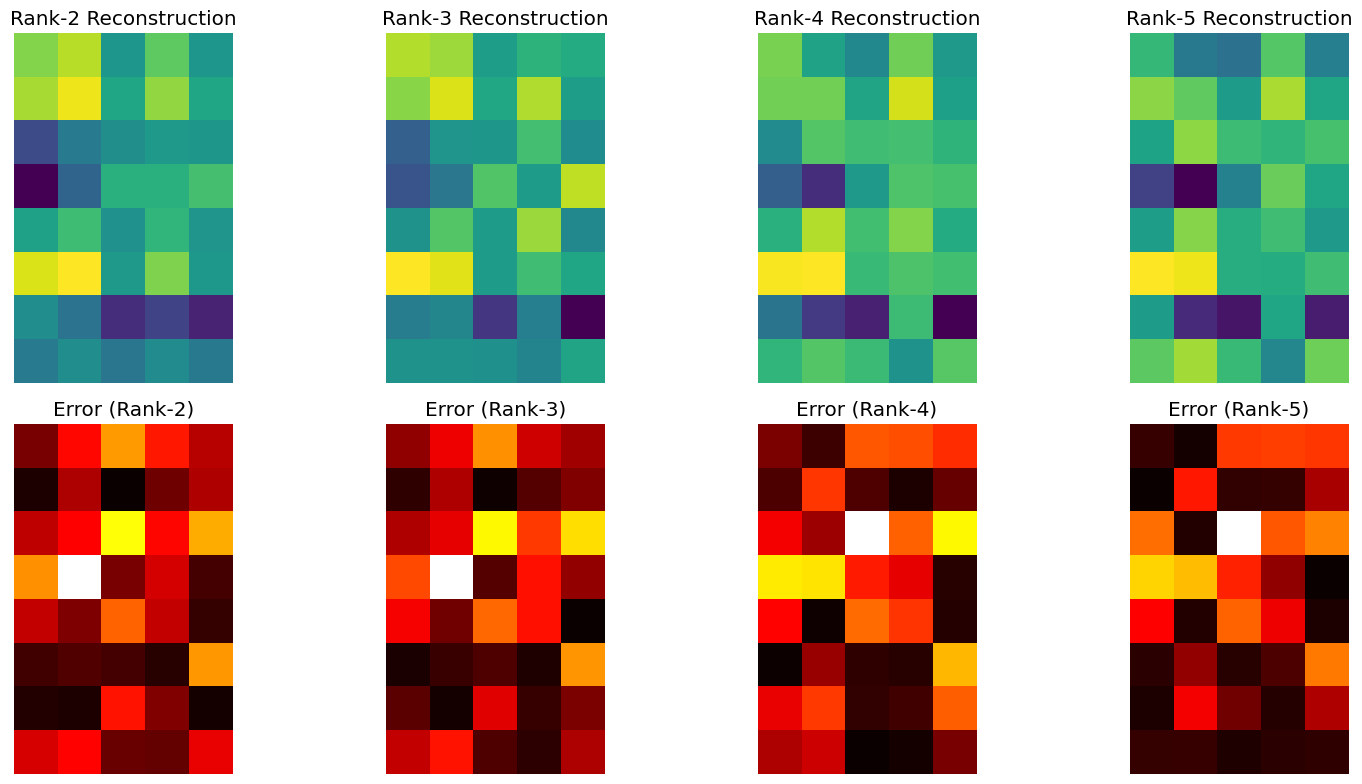

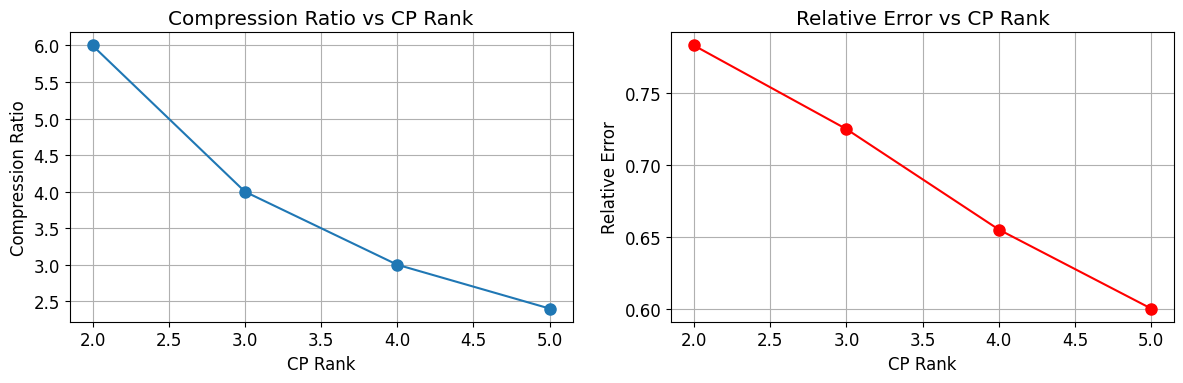


CP分解不同秩的详细结果:
Rank	Compression Ratio	Relative Error
----	-----------------	--------------
2	6.00			0.783377
3	4.00			0.725117
4	3.00			0.655080
5	2.40			0.599979


In [14]:
# 比较不同CP秩下的分解效果
cp_ranks = [2, 3, 4, 5]
cp_errors, cp_compression_ratios = compare_cp_ranks(original_tensor, cp_ranks)

# 打印详细结果
print("\nCP分解不同秩的详细结果:")
print("Rank\tCompression Ratio\tRelative Error")
print("----\t-----------------\t--------------")
for rank, ratio, error in zip(cp_ranks, cp_compression_ratios, cp_errors):
    print(f"{rank}\t{ratio:.2f}\t\t\t{error:.6f}")

上图展示了CP分解的效果。CP分解将张量分解为多个秩1张量的和，每个成分由三个因子向量的外积组成。

与Tucker分解相比，CP分解的结构更简单，没有核心张量，但在某些情况下可能需要更多的成分来达到相同的精度。CP分解特别适合处理具有多线性结构的数据。


## 非负矩阵分解(NMF)
非负矩阵分解是一种约束矩阵分解方法，要求原始矩阵和分解得到的因子矩阵都是非负的。NMF将非负矩阵V分解为两个非负矩阵W和H的乘积：V ≈ WH。

NMF在图像处理、文本挖掘和推荐系统等领域有广泛应用，因为它能够学习到数据的部分表示。

In [15]:
from sklearn.decomposition import NMF

def nmf_decomposition(matrix, n_components):
    """对非负矩阵进行NMF分解"""
    # 确保矩阵是非负的
    matrix_np = torch.abs(matrix).detach().numpy()
    
    # 进行NMF分解
    nmf = NMF(n_components=n_components, random_state=42, max_iter=1000)
    W = nmf.fit_transform(matrix_np)
    H = nmf.components_
    
    # 转回PyTorch张量
    W_tensor = torch.tensor(W, dtype=torch.float32)
    H_tensor = torch.tensor(H, dtype=torch.float32)
    
    return W_tensor, H_tensor

def visualize_nmf_decomposition(original, W, H, title_prefix="NMF"):
    """可视化NMF分解结果"""
    # 重建矩阵
    reconstructed = W @ H
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # 原始矩阵
    im1 = axes[0, 0].imshow(original.detach().numpy(), cmap='viridis')
    axes[0, 0].set_title('Original Matrix')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # W矩阵 (基矩阵)
    im2 = axes[0, 1].imshow(W.detach().numpy(), cmap='viridis')
    axes[0, 1].set_title(f'{title_prefix} Basis Matrix W')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # H矩阵 (系数矩阵)
    im3 = axes[0, 2].imshow(H.detach().numpy(), cmap='viridis')
    axes[0, 2].set_title(f'{title_prefix} Coefficient Matrix H')
    plt.colorbar(im3, ax=axes[0, 2])
    
    # 重建矩阵
    im4 = axes[1, 0].imshow(reconstructed.detach().numpy(), cmap='viridis')
    axes[1, 0].set_title('Reconstructed Matrix')
    plt.colorbar(im4, ax=axes[1, 0])
    
    # 误差
    error = torch.abs(original - reconstructed)
    im5 = axes[1, 1].imshow(error.detach().numpy(), cmap='hot')
    axes[1, 1].set_title('Reconstruction Error')
    plt.colorbar(im5, ax=axes[1, 1])
    
    # 基向量可视化
    n_components = W.shape[1]
    colors = plt.cm.Set3(np.linspace(0, 1, n_components))
    for i in range(min(n_components, 5)):  # 最多显示5个基向量
        axes[1, 2].plot(W[:, i].detach().numpy(), color=colors[i], 
                       label=f'Basis {i+1}', linewidth=2)
    axes[1, 2].set_title('Basis Vectors')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def compare_nmf_components(original_matrix, component_list):
    """比较不同成分数下的NMF效果"""
    errors = []
    compression_ratios = []
    original_params = original_matrix.numel()
    
    fig, axes = plt.subplots(2, len(component_list), figsize=(4*len(component_list), 8))
    
    for i, n_comp in enumerate(component_list):
        # NMF分解
        W, H = nmf_decomposition(original_matrix, n_comp)
        reconstructed = W @ H
        
        # 计算误差和压缩率
        error = torch.norm(original_matrix - reconstructed) / torch.norm(original_matrix)
        errors.append(error.item())
        
        compressed_params = W.numel() + H.numel()
        compression_ratio = original_params / compressed_params
        compression_ratios.append(compression_ratio)
        
        # 可视化
        axes[0, i].imshow(reconstructed.detach().numpy(), cmap='viridis')
        axes[0, i].set_title(f'Components={n_comp}')
        axes[0, i].axis('off')
        
        error_img = torch.abs(original_matrix - reconstructed)
        axes[1, i].imshow(error_img.detach().numpy(), cmap='hot')
        axes[1, i].set_title(f'Error (Comp={n_comp})')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 显示统计结果
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(component_list, compression_ratios, 'o-', markersize=8, color='blue')
    ax1.set_title('Compression Ratio vs Components')
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Compression Ratio')
    ax1.grid(True)
    
    ax2.plot(component_list, errors, 'o-', markersize=8, color='red')
    ax2.set_title('Relative Error vs Components')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Relative Error')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return errors, compression_ratios

非负矩阵分解(NMF)实验:


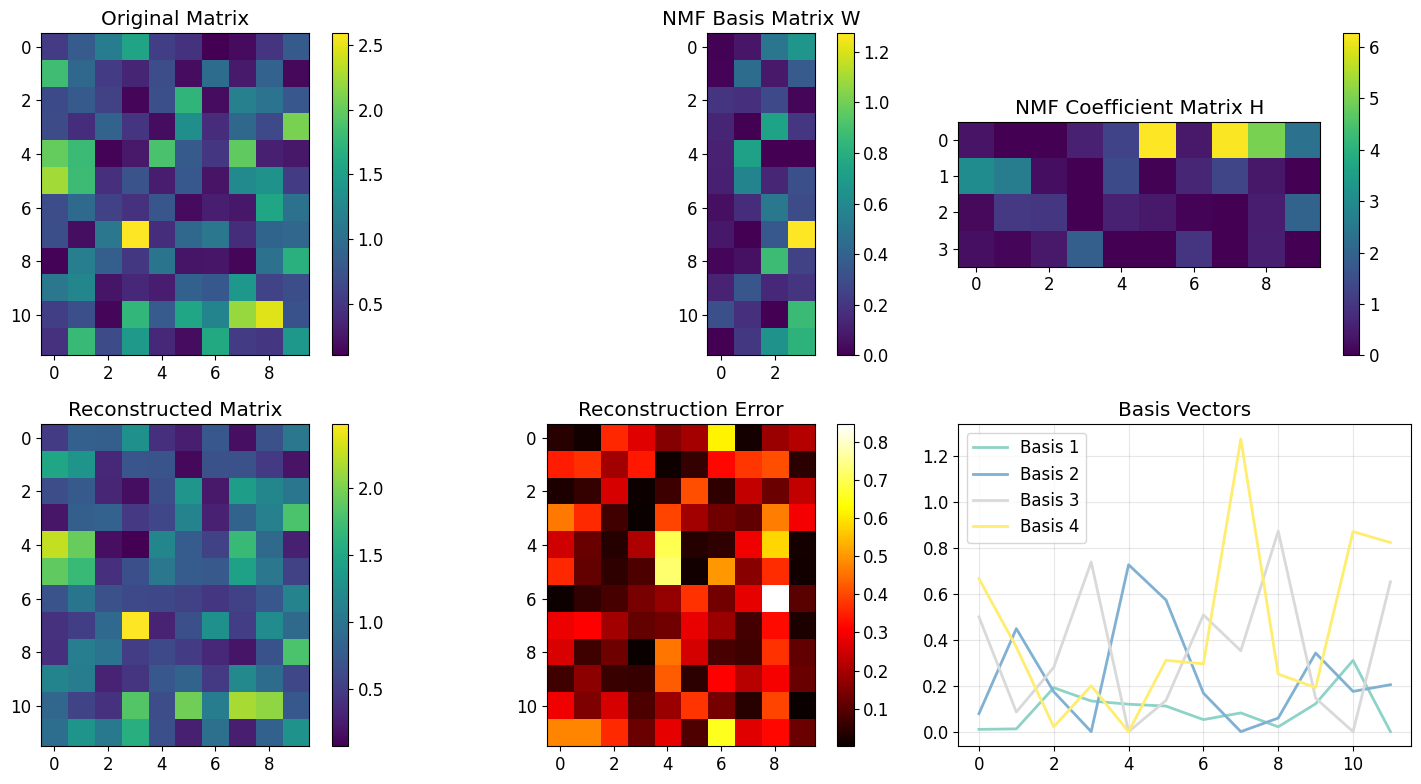

NMF - 原始参数量: 120
NMF - 压缩后参数量: 88
NMF - 压缩率: 1.36
NMF - 相对误差: 0.272304


In [16]:
# 创建一个非负矩阵进行NMF分解
nmf_matrix = torch.abs(torch.randn(12, 10)) + 0.1  # 确保非负

print("非负矩阵分解(NMF)实验:")

# 设置成分数
n_components = 4

# 进行NMF分解
W, H = nmf_decomposition(nmf_matrix, n_components)

# 可视化分解结果
visualize_nmf_decomposition(nmf_matrix, W, H)

# 计算压缩效果
nmf_original_params = nmf_matrix.numel()
nmf_compressed_params = W.numel() + H.numel()
nmf_compression_ratio = nmf_original_params / nmf_compressed_params
nmf_reconstructed = W @ H
nmf_relative_error = torch.norm(nmf_matrix - nmf_reconstructed) / torch.norm(nmf_matrix)

print(f'NMF - 原始参数量: {nmf_original_params}')
print(f'NMF - 压缩后参数量: {nmf_compressed_params}')
print(f'NMF - 压缩率: {nmf_compression_ratio:.2f}')
print(f'NMF - 相对误差: {nmf_relative_error.item():.6f}')

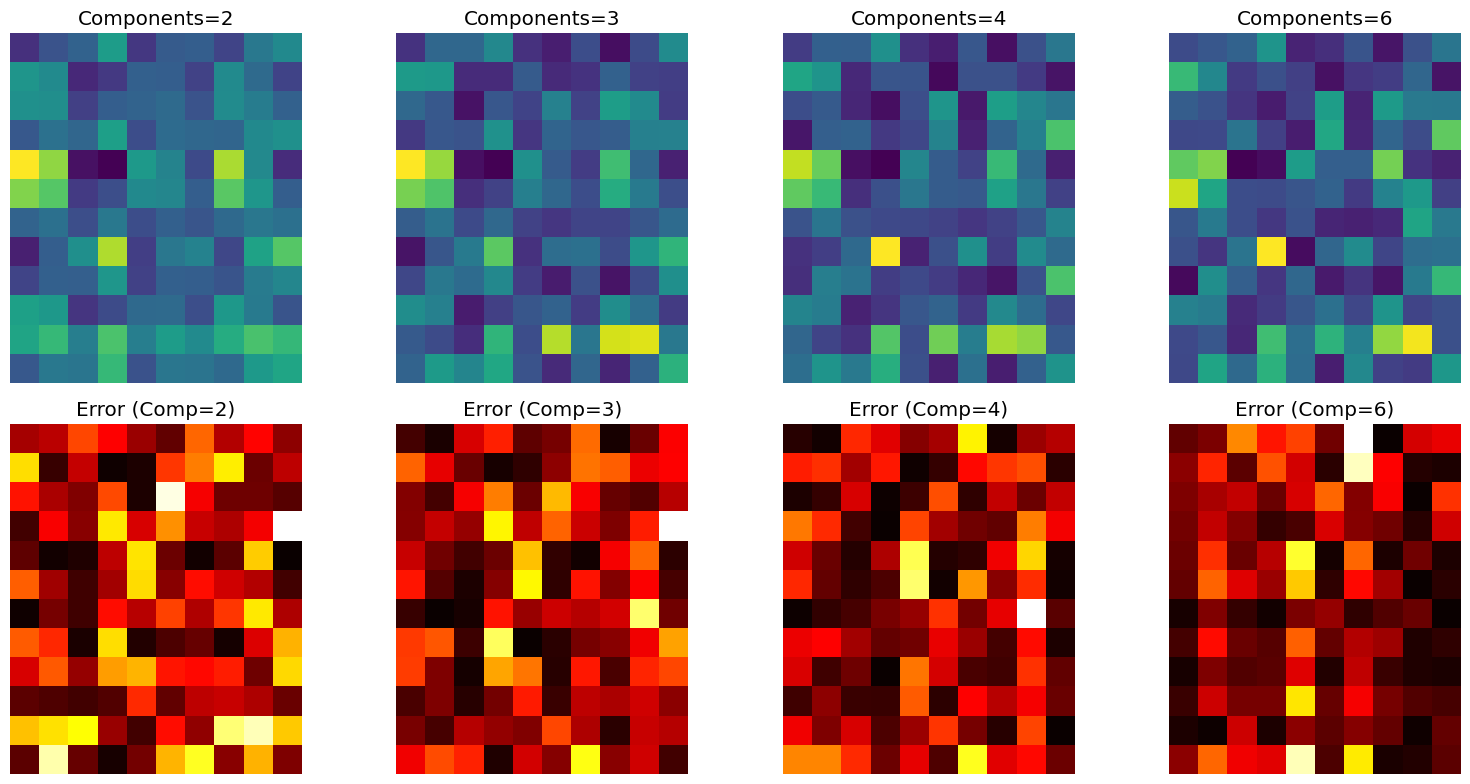

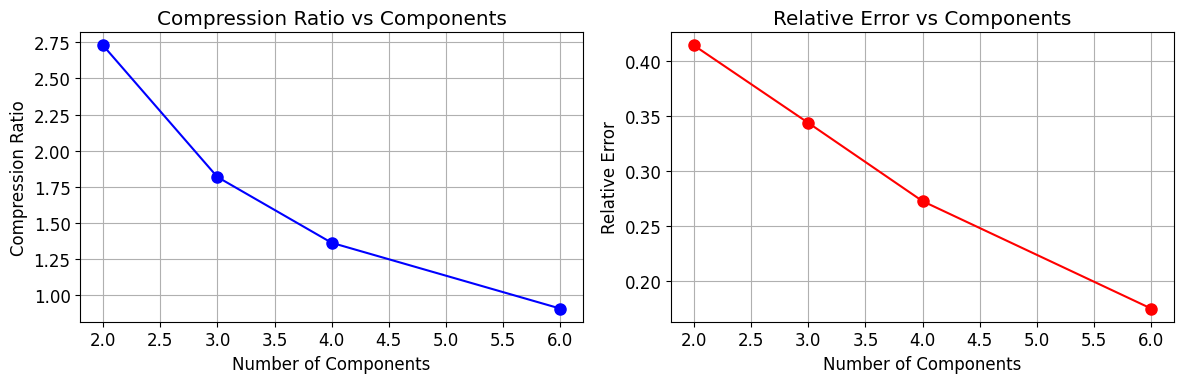


NMF不同成分数的详细结果:
Components	Compression Ratio	Relative Error
----------	-----------------	--------------
2		2.73			0.413810
3		1.82			0.343443
4		1.36			0.272304
6		0.91			0.174703


In [17]:
# 比较不同成分数的NMF效果
component_list = [2, 3, 4, 6]
nmf_errors, nmf_compression_ratios = compare_nmf_components(nmf_matrix, component_list)

print("\nNMF不同成分数的详细结果:")
print("Components\tCompression Ratio\tRelative Error")
print("----------\t-----------------\t--------------")
for comp, ratio, error in zip(component_list, nmf_compression_ratios, nmf_errors):
    print(f"{comp}\t\t{ratio:.2f}\t\t\t{error:.6f}")

上图展示了非负矩阵分解的效果。NMF将原始矩阵分解为基矩阵W和系数矩阵H，其中W的每一列代表一个基向量，H的每一行代表对应基向量的系数。

NMF的优势在于其非负约束使得分解结果具有很好的可解释性，基向量通常对应数据的某些局部特征或模式。右下角的基向量图显示了学习到的不同模式。

与SVD等方法相比，NMF更适合处理本质上非负的数据，如图像像素值、文档词频等。

我们展示了四种重要的低秩分解方法：

**SVD分解**：通用的矩阵分解方法，适用于任意矩阵，在图像压缩等领域应用广泛。

**Tucker分解**：高阶张量分解，通过核心张量和因子矩阵实现灵活的多维数据压缩。

**CP分解**：将张量表示为秩1张量的和，结构简单，适合多线性数据。

**NMF分解**：约束分解方法，保证非负性，结果具有良好的可解释性。

每种方法都有其特定的应用场景和优势，在神经网络压缩中可以根据数据特性选择合适的分解方法。